In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import datetime
import itertools
from time import sleep
import os
import seaborn as sns

In [2]:
# get the DF used for setting the weights and analysis
print datetime.datetime.now()
validFilePaths = []
for f in os.listdir("data/anomaly_data"):
    filePath = os.path.join("data/anomaly_data", f)
    if os.path.isdir(filePath):
        continue
    if os.stat(filePath).st_size <= 3:
        continue
    validFilePaths.append(filePath)
    
numF = int(0.1 * len(validFilePaths))
print 'Using this many files {0}'.format(numF)
validFilePaths = np.random.choice(validFilePaths, numF, replace=False)
df_list = (pd.read_csv(f) for f in validFilePaths)
df = pd.concat(df_list, ignore_index=True)
df1 = df[df['radiant_win'].notnull()]

2017-05-19 07:43:37.880091
Using this many files 995


In [3]:

df2 = pd.DataFrame(np.loadtxt('data/goodAnomaliesResidual.csv', delimiter = ','), 
                 columns = ["match_id", "residual"])

df = df1.merge(df2, left_on='match_id', right_on='match_id')

matchDictionary = {}
heroColumns = [filter(lambda x: z in x, df.columns) for z in ['hero_id']][0]

# for each row, this function will return all the heroes that the match belongs in
# for example, if the match had an AM and Spectre, we should place this match in each of those bags
def heroesForMatch(row):
    pass

In [4]:
df = df[~df['match_id'].duplicated()]

In [5]:
df = df.sort_values(by='residual', ascending=False)

In [6]:
df['match_id'].values.tolist()

[3123855616,
 3123784960,
 3123784448,
 3123927040,
 3123664384,
 3123780608,
 3123939584,
 3123936768,
 3123949056,
 3123798784,
 3123779328,
 3123583232,
 3123720960,
 3123711744,
 3123879424,
 3123732480,
 3123439872,
 3123624704,
 3123616512,
 3123303936,
 3123820800,
 3123728128,
 3123762432,
 3123457024,
 3123582976,
 3123739904,
 3123549952,
 3123660032,
 3123738368,
 3123437312,
 3123510528,
 3123248384,
 3123585792,
 3123465216,
 3123254016,
 3123768064,
 3123259904,
 3123005184,
 3123094016,
 3123872768,
 3123165440,
 3123599360,
 3123570176,
 3123349504,
 3123313152,
 3123266048,
 3122989056,
 3123288064,
 3123439616,
 3123261184,
 3123273472,
 3122991872,
 3123658496,
 3123283456,
 3123216128,
 3123192832,
 3123229440,
 3123179008,
 3123207424,
 3123015424]

In [10]:
sns.distplot(df['residual'].values.tolist())

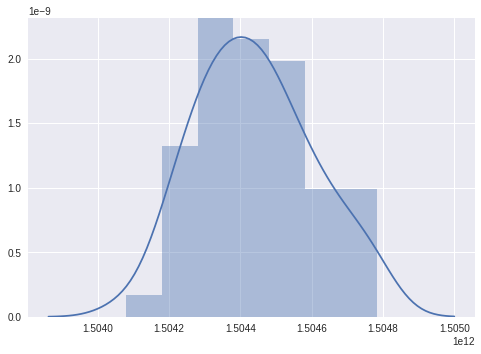

In [11]:
plt.show()

In [9]:
len(df)

60

In [53]:
plt.close()

In [66]:
residuals = df['residual'].values.tolist()

In [67]:
np.max(residuals) - np.min(residuals)

4188012544.0

In [13]:
df['residual']

248    1.504783e+12
191    1.504780e+12
9      1.504754e+12
122    1.504753e+12
237    1.504693e+12
58     1.504686e+12
63     1.504664e+12
19     1.504656e+12
43     1.504654e+12
228    1.504611e+12
97     1.504599e+12
83     1.504587e+12
218    1.504582e+12
223    1.504571e+12
98     1.504558e+12
170    1.504546e+12
212    1.504544e+12
69     1.504520e+12
114    1.504514e+12
119    1.504504e+12
110    1.504497e+12
185    1.504486e+12
87     1.504485e+12
201    1.504482e+12
243    1.504465e+12
14     1.504461e+12
139    1.504448e+12
214    1.504441e+12
101    1.504438e+12
245    1.504433e+12
35     1.504428e+12
138    1.504423e+12
6      1.504416e+12
200    1.504403e+12
127    1.504398e+12
232    1.504392e+12
105    1.504384e+12
88     1.504364e+12
183    1.504362e+12
145    1.504353e+12
53     1.504350e+12
203    1.504336e+12
76     1.504334e+12
157    1.504329e+12
0      1.504321e+12
209    1.504315e+12
169    1.504314e+12
148    1.504310e+12
193    1.504281e+12
92     1.504280e+12
